# Réseau de chambres magmatique

Lorette Drique et Sylvain Brisson 
Master géophysique de l'IPGP
Encadré par Raphaël Grandin

## I. Modélisation d'un écoulement au sein d'un réseau de chambres magmatiques

### Modélisation du problème

On suppose $G$ un graphe valué de chambres magmatiques. Les valeurs des arrêtes $\lambda_{ij}$ représente la conductivité hydraulique entre la chambre $i$ et la chambre $j$, les valeurs prisent pas les sommets $b_i$ représentent la compressibilité de la chambre.

Par conservation de la masse on obtient l'équation suivante : 
$$
b_i\dot p_i = \sum_{j\neq i} \lambda _{ij}(p_j - p_i) + f_i
$$

Avec $p_i$ la pression dans la chambre $i$ et f_i un terme source.

On peut réecrire ce système sous la forme :
$$
\dot p_i = A_{ij}p_j + f_i
$$

Avec A telle que :
$$
A_{ij} = 
\begin{cases}
    \lambda_{ij}/b_i & \text{si } i \ne j \\
        -\left(\sum_{k\neq i}\lambda_{ik}\right)/b_i & \text{si } i = j
\end{cases}
$$

On se propose d'implémenter un tel système avec la bibliothèse networkx puis de résoudre ce problème numériquement puis analytiquement.

### Implémentation du problème avec networkx

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import matplotlib as mpl

import matplotlib
matplotlib.rc('figure', figsize=(10, 5))
plt.style.use('ggplot')

In [2]:
# Création d'un graph à N chambres

def graph_1D_N_chambers(N):
    """
    Graph 1D de N chambres magmatiques, compressibilités et conductivités constantes
    Chambre 0 : compressibilité infinie
    """
    
    G = nx.Graph()
    
    # 1. ajout des noeuds
    G.add_node(0, compressibility=1e12)
    for i in range(1,N+1):
        G.add_node(i, compressibility=1)
        
    # 2. ajout des arrêtes
    for i in range(N):
        G.add_edge(i, i+1, conductivity=1)
        
    return G

In [3]:
# fonctions auxilliaires

def get_compressibility(G,i):
    """Retourne la compressibilité de la chambre i"""
    return G.nodes[i]["compressibility"]

def get_conductivity(G,i,j):
    """Retourne la conductivité du conduit entre i et j"""
    try :
        # print(i,j,G.get_edge_data(i,j)["conductivity"])
        return G.get_edge_data(i,j)["conductivity"]
    except:
        # print(i,j,0)
        return 0.

In [4]:
def draw_chambers(G, node_size_factor=400, edge_width_factor=4):   
    
    seed = 13648
    pos = nx.spring_layout(G, seed=seed)
    
    node_sizes = [G.nodes[node]["compressibility"]*node_size_factor for node in G.nodes]
    node_sizes[0] = 5*node_size_factor
    edge_sizes = [G.edges[edge]["conductivity"]*edge_width_factor for edge in G.edges]

    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="indigo")
    nx.draw_networkx_edges(
        G,
        pos,
        node_size=node_sizes,
        width=edge_sizes,
    )
    
    nx.draw_networkx_labels(G, pos, font_color="w")

    ax = plt.gca()
    ax.set_axis_off()
    plt.show()

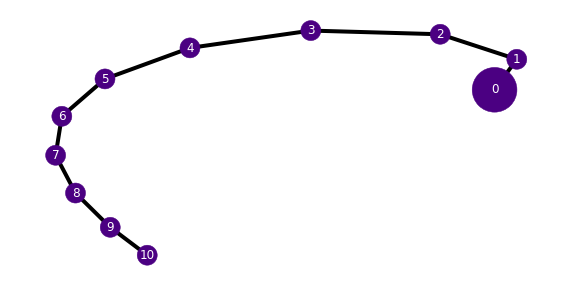

In [5]:
G = graph_1D_N_chambers(10)

draw_chambers(G)

### Résolution numérique du système

Appel à la fonction `odeint` de scipy.

In [6]:
# Construction de la matrice du système A

def build_matrix_A(G):
    """ 
    Construit à partir de la description du système sous forme de graph la matrice A du système dp/dt = Ap
    """
    
    # Initiation matrice
    N = len(G) - 1 # N'inclut pas la source 
    A = np.zeros((N,N))
    
    # Remplissage des coefficients 
    for i in range(1,N+1):
        for j in range(1,N+1):
            
            # Terme en i,i
            if j == i: 
                # print("i=j",i)
                A[i-1,i-1] = - sum([get_conductivity(G,i,k) for k in range(N+1) if k != i]) / get_compressibility(G,i)
                
            # Terme en i,j (j!=i)
            else : 
                # print("i!=j",i,j)
                A[i-1,j-1] = get_conductivity(G,i,j)/get_compressibility(G,i)
        
    return A 

# Construction du vecteur de pondération du terme source
def build_vector_B(G):
    
    # Initiation matrice
    N = len(G) - 1 # N'inclut pas la source 
    B = np.zeros(N)
    
    for i in range(1,N+1):
        B[i-1] = get_conductivity(G,0,i)/get_compressibility(G,i)
        
    return B
        

In [7]:
def compute_pressure_time_serie(G, source, t_max, p0):
    
    # Domaine temporel de résolution (système adimentionalisé : temps caractéristique ~ 1)
    t_space = np.linspace(0.,t_max,1000)
    
    # Construction matrice du système 
    A = build_matrix_A(G)
    B = build_vector_B(G)
    
    source_B = lambda t : B * source(t)

    # Résolution du système
    def system(p, t):
        dpdt = np.dot(A, p) + source_B(t)
        return dpdt 

    p = odeint(system, p0, t_space)
    
    return p

In [8]:
# Construction du graph des chambres
N = 10
G = graph_1D_N_chambers(N) 

# Conditions initiales
p0 = np.zeros(N)

# définition du terme source : ici marche de pression dans la chambre 0
def source(t, t_s=0.): return 1 if t >= t_s else 0

# temps résolution
t_max = 20.

p = compute_pressure_time_serie(G, source, t_max, p0)

[]

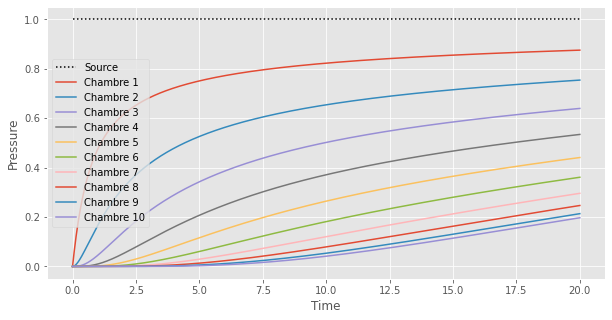

In [9]:
# Tracé des pressions dans les chambres au cours du temps 
t_space = np.linspace(0, t_max, p.shape[0])
plt.plot(t_space, [source(t_) for t_ in t_space], label="Source", color="k", ls=":")

for i in range(N):
    plt.plot(t_space, p[:,i], label=f"Chambre {i+1}")
    
plt.xlabel("Time")
plt.ylabel("Pressure")
plt.legend()
plt.plot()

[]

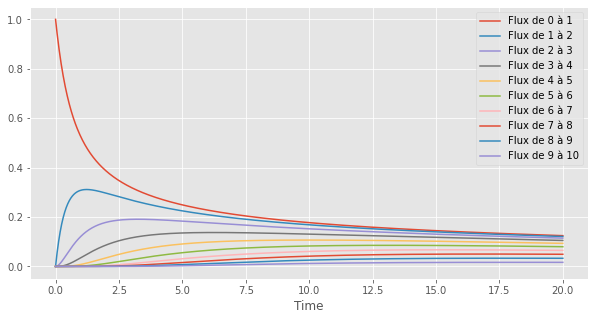

In [10]:
# Calcul des flux entre les chambres

p2 = np.zeros((p.shape[0],N+1))
p2[:,0] = np.array([source(t_) for t_ in t_space])
p2[:,1:] = p

flow = {}

for i in range(0,N+1):
    for j in range(i+1,N+1):            
            if get_conductivity(G,i,j) > 0 :
                flow[(i,j)] = get_conductivity(G,i,j) * (p2[:,i] - p2[:,j])
            
# plot it 
for (i,j),flow_ts in flow.items():
    plt.plot(t_space, flow_ts, label=f"Flux de {i} à {j}")
    
plt.xlabel("Time")
plt.legend()
plt.plot()
    

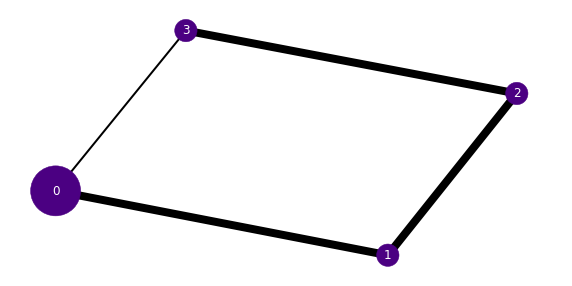

In [31]:
# Exemple plus complexe
G = nx.Graph()

# 1. ajout des noeuds
G.add_node(0, compressibility=1e12)
for i in range(1,4):
    G.add_node(i, compressibility=1)
    
# 2. ajout des arrêtes
G.add_edge(0, 1, conductivity=4)
G.add_edge(1, 2, conductivity=4)
G.add_edge(2, 3, conductivity=4)
G.add_edge(0, 3, conductivity=1)

draw_chambers(G, node_size_factor=500, edge_width_factor=2)

In [32]:
# Construction du graph des chambres
N = len(G) - 1

# Conditions initiales
p0 = np.zeros(N)

# définition du terme source : ici marche de pression dans la chambre 0
def source(t, t_s=0.): return 1 if t >= t_s else 0

# temps résolution
t_max = 5.

p = compute_pressure_time_serie(G, source, t_max, p0)

[]

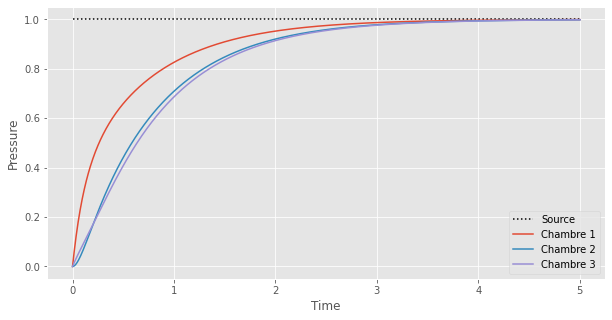

In [33]:
# # Tracé des pressions dans les 3 chambres au cours du temps 
# plt.plot(t, [source(t_)[0] for t_ in t], label="Source", color="k", ls=":")

t_space = np.linspace(0, t_max, p.shape[0])
plt.plot(t_space, [source(t_) for t_ in t_space], label="Source", color="k", ls=":")

for i in range(N):
    plt.plot(t_space, p[:,i], label=f"Chambre {i+1}")
    
plt.xlabel("Time")
plt.ylabel("Pressure")

# plt.xlim([0, 10])

plt.legend()
plt.plot()

[]

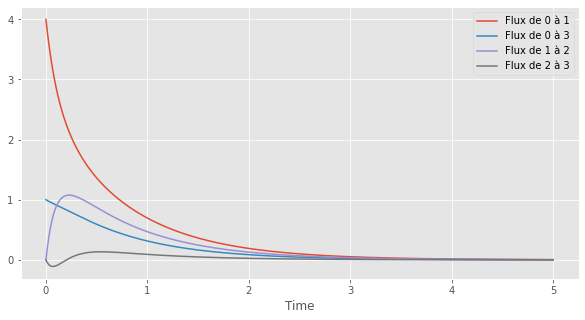

In [34]:
# Compute flow between chambers

p2 = np.zeros((p.shape[0],N+1))
p2[:,0] = np.array([source(t_) for t_ in t_space])
p2[:,1:] = p

flow = {}

for i in range(0,N+1):
    for j in range(i+1,N+1):            
            if get_conductivity(G,i,j) > 0 :
                flow[(i,j)] = get_conductivity(G,i,j) * (p2[:,i] - p2[:,j])
            
# plot it 
for (i,j),flow_ts in flow.items():
    plt.plot(t_space, flow_ts, label=f"Flux de {i} à {j}")
    
plt.xlabel("Time")
plt.legend()
plt.plot()

### Résolution analytique

On applique à notre système la transformée de Laplace, on recourt au module de calcul symbolique sympy pour :
1. Définir la matrice gouvernant le système
2. L'inverser
3. Résoudre le système en multipliant l'inverse par le terme source
4. Appliquer une transformée de laplace inverse

In [11]:
from sympy import Matrix, symbols, print_latex
from sympy import laplace_transform, inverse_laplace_transform
from sympy import lambdify

In [12]:
# définition des symboles
s,t = symbols('s,t') # coordonée de laplace et temps 

In [15]:
# COnstruction de la matrice M = sI - A

N = 5
G = graph_1D_N_chambers(N) 
A = build_matrix_A(G)


M = Matrix(np.eye(5)*s - A) 

# inversion 
iM = M.inv()
iM

Matrix([
[(1.0*s**4 + 7.0*s**3 + 15.0*s**2 + 10.0*s + 1.0)/(1.0*s**5 + 9.0*s**4 + 28.0*s**3 + 35.0*s**2 + 15.0*s + 1.0),              (1.0*s**3 + 5.0*s**2 + 6.0*s + 1.0)/(1.0*s**5 + 9.0*s**4 + 28.0*s**3 + 35.0*s**2 + 15.0*s + 1.0),                         (1.0*s**2 + 3.0*s + 1.0)/(1.0*s**5 + 9.0*s**4 + 28.0*s**3 + 35.0*s**2 + 15.0*s + 1.0),                                    (1.0*s + 1.0)/(1.0*s**5 + 9.0*s**4 + 28.0*s**3 + 35.0*s**2 + 15.0*s + 1.0),                                              1.0/(1.0*s**5 + 9.0*s**4 + 28.0*s**3 + 35.0*s**2 + 15.0*s + 1.0)],
[             (1.0*s**3 + 5.0*s**2 + 6.0*s + 1.0)/(1.0*s**5 + 9.0*s**4 + 28.0*s**3 + 35.0*s**2 + 15.0*s + 1.0), (1.0*s**4 + 7.0*s**3 + 16.0*s**2 + 13.0*s + 2.0)/(1.0*s**5 + 9.0*s**4 + 28.0*s**3 + 35.0*s**2 + 15.0*s + 1.0),              (1.0*s**3 + 5.0*s**2 + 7.0*s + 2.0)/(1.0*s**5 + 9.0*s**4 + 28.0*s**3 + 35.0*s**2 + 15.0*s + 1.0),                         (1.0*s**2 + 3.0*s + 2.0)/(1.0*s**5 + 9.0*s**4 + 28.0*s**3 + 35.0*s**2 + 15.0

In [18]:
# Définition du terme source 
# TL d'une fonction heaviside : 1/s
f_tmp = [0 for _ in range(N)]
f_tmp[0] = 1/s
f_L_vector = Matrix(f_tmp)

# Calcul de l'expression des pression (toujours en Laplace)
p_L_vector = iM * f_L_vector
p_L_vector

Matrix([
[(1.0*s**4 + 7.0*s**3 + 15.0*s**2 + 10.0*s + 1.0)/(s*(1.0*s**5 + 9.0*s**4 + 28.0*s**3 + 35.0*s**2 + 15.0*s + 1.0))],
[             (1.0*s**3 + 5.0*s**2 + 6.0*s + 1.0)/(s*(1.0*s**5 + 9.0*s**4 + 28.0*s**3 + 35.0*s**2 + 15.0*s + 1.0))],
[                        (1.0*s**2 + 3.0*s + 1.0)/(s*(1.0*s**5 + 9.0*s**4 + 28.0*s**3 + 35.0*s**2 + 15.0*s + 1.0))],
[                                   (1.0*s + 1.0)/(s*(1.0*s**5 + 9.0*s**4 + 28.0*s**3 + 35.0*s**2 + 15.0*s + 1.0))],
[                                             1.0/(s*(1.0*s**5 + 9.0*s**4 + 28.0*s**3 + 35.0*s**2 + 15.0*s + 1.0))]])

In [19]:
# Transformée de laplace inverse 
p_symb = {}
for i in range(N):
    try : 
        p_symb[i+1] = inverse_laplace_transform(p_L_vector[i], s, t)
    except ValueError:
        p_symb[i+1] = "Sympy error"

In [23]:
p_symb

{1: 'Sympy error',
 2: 'Sympy error',
 3: 'Sympy error',
 4: 'Sympy error',
 5: 'Sympy error'}

### Comparaison méthodes numériques et symboliques

In [21]:
# Conditions initiales
p0 = np.zeros(N)

# définition du terme source : ici marche de pression dans la chambre 0
def source(t, t_s=0.): return 1 if t >= t_s else 0

# temps résolution
t_max = 20.

p = compute_pressure_time_serie(G, source, t_max, p0)

[]

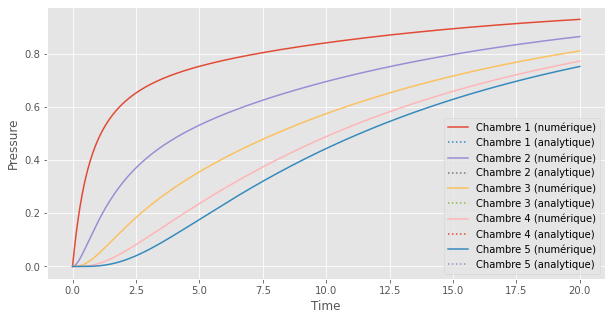

In [22]:
t_space = np.linspace(0, t_max, p.shape[0])
N_t = len(t_space)

p_analytique = np.zeros((N_t, N))
for i in range(N):
    if p_symb[i+1] == "Sympy error":
        p_analytique[:,i] = np.nan 
    else : 
        p_analytique[:,i] = lambdify(t, p_symb[i+1], "numpy")(t_space)

for i in range(N):
    plt.plot(t_space, p[:,i], label=f"Chambre {i+1} (numérique)")
    plt.plot(t_space, p_analytique[:,i], label=f"Chambre {i+1} (analytique)", ls=":")
    
plt.xlabel("Time")
plt.ylabel("Pressure")
plt.legend()
plt.plot()
